## Tabular Data with fastai

In [1]:
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

### Blue Book for Bulldozers Kaggle Competition

In [2]:
# pick a destination path
path = URLs.path('bluebook')
path

Path('/Users/chhilty/.fastai/archive/bluebook')

In [3]:
# set base path
Path.BASE_PATH = path

In [7]:
# download the dataset
if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

  0%|          | 0.00/48.4M [00:00<?, ?B/s]

100%|██████████| 48.4M/48.4M [00:11<00:00, 4.41MB/s]


(#7) [Path('random_forest_benchmark_test.csv'),Path('Valid.csv'),Path('median_benchmark.csv'),Path('Test.csv'),Path('ValidSolution.csv'),Path('Machine_Appendix.csv'),Path('TrainAndValid.csv')]

### Inspect the Data

In [34]:
# read in the data
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [35]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [36]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN


#### Handle Ordinal Columns

In [37]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [38]:
# set correct ordinal order
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

In [39]:
df['ProductSize'].dtypes

dtype('O')

In [40]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [41]:
df['ProductSize'].dtypes

CategoricalDtype(categories=['Large', 'Large / Medium', 'Medium', 'Small', 'Mini',
                  'Compact'],
                 ordered=True)

#### Target Variable

In [42]:
# the dependent variable we need to predict is the log of the sale price
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

#### Date Handling

In [43]:
# convert date to meaningful variable
cols_before = df.columns

df = add_datepart(df, 'saledate')

In [51]:
# inspect our newly added columns
set(df.columns) - set(cols_before)

{'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleElapsed',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start',
 'saleMonth',
 'saleWeek',
 'saleYear'}

In [52]:
# make same for test set
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [54]:
# lets inspect our new columns in another way
' '.join(o for o in df.columns if o.startswith('sale'))

'saleWeek saleYear saleMonth saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

#### Using TabularPandas and TabularProc 

In [62]:
# split our time series data
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [64]:
# define continuous and categorical columns
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
cont[:3], cat[:3]

(['SalesID', 'MachineID', 'ModelID'], ['saleWeek', 'UsageBand', 'fiModelDesc'])

Hmm...I am not really happy about MachineID beeing a continous variable though..

In [66]:
# define processings for our data
procs = [Categorify, FillMissing]

In [67]:
# create TabularPandas object
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
len(to.train),len(to.valid)

(404710, 7988)

In [68]:
# show some data
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [71]:
# show categorical and continous
to.cat_names, to.cont_names

((#54) ['saleWeek','UsageBand','fiModelDesc','fiBaseModel','fiSecondaryDesc','fiModelSeries','fiModelDescriptor','ProductSize','fiProductClassDesc','state'...],
 (#12) ['SalesID','MachineID','ModelID','datasource','auctioneerID','YearMade','MachineHoursCurrentMeter','saleYear','saleMonth','saleDay'...])

In [72]:
# show power of TabularPandas
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], 
                    [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


The group is still present in the TabularPandas but the underlying items are now numeric.

In [77]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [78]:
# save our data for later access
(path/'to.pkl').save(to)

### Decision Tree

In [80]:
# reload model for demonstration
to = None
to = (path/'to.pkl').load()
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [193]:
# split dependent and independent vars
xs, y = to.train.xs, to.train.y
xs_valid, y_valid = to.valid.xs, to.valid.y

In [194]:
# now we can create our decision tree (keep it simple with 4 leaf nodes)
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

In [195]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """Draws a representation of a random forest in IPython."""
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

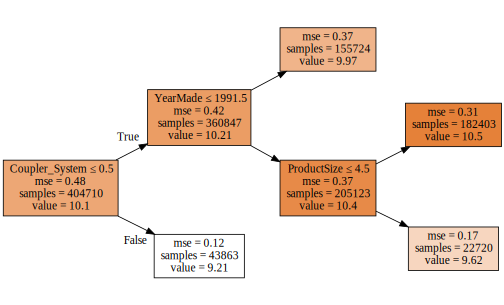

In [196]:
from sklearn.tree import export_graphviz

draw_tree(m, xs, size=7, precision=2)

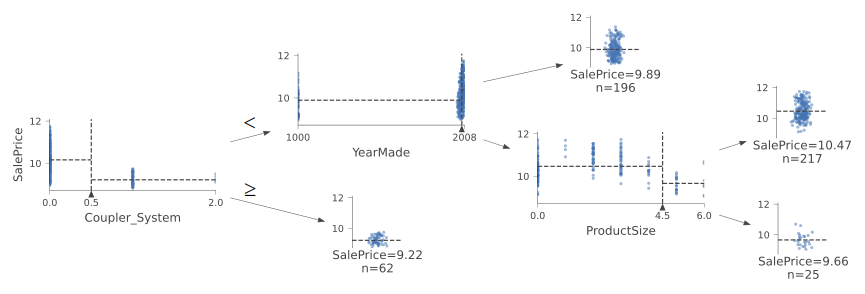

In [197]:
# another way of visualizing our tree
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [198]:
# input year made with a reasonable year
xs.loc[xs['YearMade'] < 1900, 'YearMade'] = 1950
xs_valid.loc[xs_valid['YearMade'] < 1900, 'YearMade'] = 1950

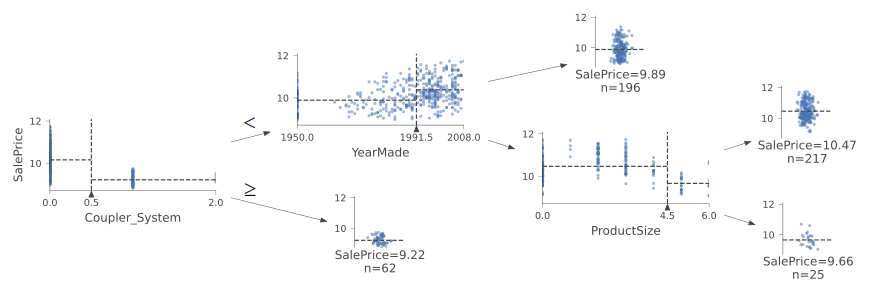

In [199]:
# with the decision a little bit nicer
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [200]:
# now lets build a bigger tree
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [201]:
# define function for RMSE
def rmse(y, y_hat): return round(math.sqrt(((y_hat-y)**2).mean()), 6)

In [202]:
# define function for evaluating the RMSE
def calculate_rmse(x, y, model=m): return rmse(model.predict(x), y)

In [203]:
# evaluate our classifier
calculate_rmse(xs, y, m)

0.0

In [204]:
# just for fun use some partial
calc_rmse = partialler(calculate_rmse, model=m)

In [205]:
calc_rmse(xs, y)

0.0

Nice performance but we need to check on the validation set.

In [206]:
calc_rmse(xs_valid, y_valid)

0.328414

In [207]:
# inspect how many leaf nodes we got
m.get_n_leaves(), len(xs), f"{(m.get_n_leaves()/len(xs)*100):.2f}%"

(324572, 404710, '80.20%')

We have for 80% of the nodes a unique leaf. Thats called overfitting.

In [208]:
# set the number of minimal samples in a leaf to 25
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs, y)
calculate_rmse(xs, y, m), calculate_rmse(xs_valid, y_valid, m)

(0.211706, 0.268764)

A much better generalization trough much less nodes.

In [209]:
m.get_n_leaves()

12400

### Random Forest

In [210]:
# create helper method for rf
def rf(xs, y, n_estimators=40, max_samples=200_000, 
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [211]:
# create a model
m = rf(xs, y)

In [212]:
# calculate our performance
calculate_rmse(xs, y, model=m), calculate_rmse(xs_valid, y_valid, model=m)

(0.171028, 0.232785)

Thats even better!

In [213]:
# show our estimators
m.estimators_[:5]

[DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=1099820965),
 DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=1480037043),
 DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=1909951384),
 DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=1002053588),
 DecisionTreeRegressor(max_features=0.5, min_samples_leaf=5,
                       random_state=1604416996)]

In [214]:
# stack all the predictions of our estimators together
preds = np.stack([t.predict(xs_valid) for t in m.estimators_])

In [215]:
preds.mean(0).shape, y_valid.shape

((7988,), (7988,))

In [216]:
# verify that the random forest really takes the mean
rmse(preds.mean(0), y_valid)

0.232785

In [217]:
# plot how the number of trees affect our accuracy
preds_incrementaly = [preds[:i] for i in range(1, 40)]

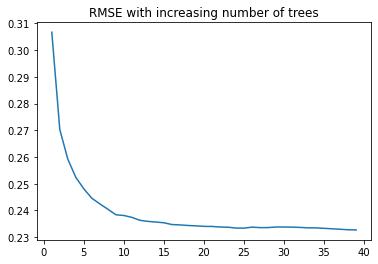

In [218]:
# and show our result
plt.plot(range(1, 40), [rmse(p.mean(0), y_valid) for p in preds_incrementaly])
plt.title('RMSE with increasing number of trees');

### Out-of-Bag Error

In [219]:
# calculate the RMSE error
calculate_rmse(xs_valid, y_valid, model=m)

0.232785

In [220]:
# calculate the OOB error
rmse(m.oob_prediction_, y)

0.210915

We can see that our OOB error is much lower than our validation set error. This means that something else is causing that error, in addition to normal generalization error. We'll discuss the reasons for this later in this chapter.

### Model Interpretation

#### Tree Variance for Prediction Confidence

In [221]:
# get all the predictions for the individual estimators
preds = np.stack([t.predict(xs_valid) for t in m.estimators_])
preds.shape

(40, 7988)

In [222]:
# get the standard deviations for our predictions
preds_std = preds.std(0)

In [223]:
# have a look at these
preds_std[:5]

array([0.21892607, 0.08079181, 0.11929675, 0.24619629, 0.12761782])

In [224]:
min(preds_std), max(preds_std)

(0.05259985211739101, 0.589248139251016)

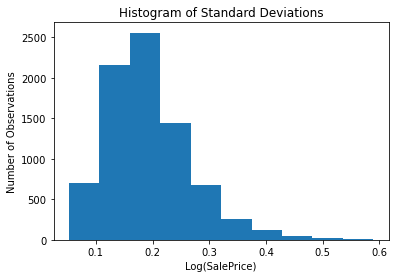

In [225]:
plt.hist(preds_std)
plt.title('Histogram of Standard Deviations')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Number of Observations');

#### Feature Importance

In [226]:
# function for creating a df from model feature importance
def rf_feat_importance(m, df):
    return pd.DataFrame({'feature':df.columns, 'importance': m.feature_importances_,
                        }).sort_values('importance', ascending=False)

In [227]:
# lets have a look
rf_feat_importance(m, xs)[:10]

,feature,importance
59,YearMade,0.174812
31,Coupler_System,0.141901
7,ProductSize,0.119035
8,fiProductClassDesc,0.075400
56,ModelID,0.055637
51,saleElapsed,0.050073
32,Grouser_Tracks,0.048019
4,fiSecondaryDesc,0.045588
2,fiModelDesc,0.031682
13,Enclosure,0.027438


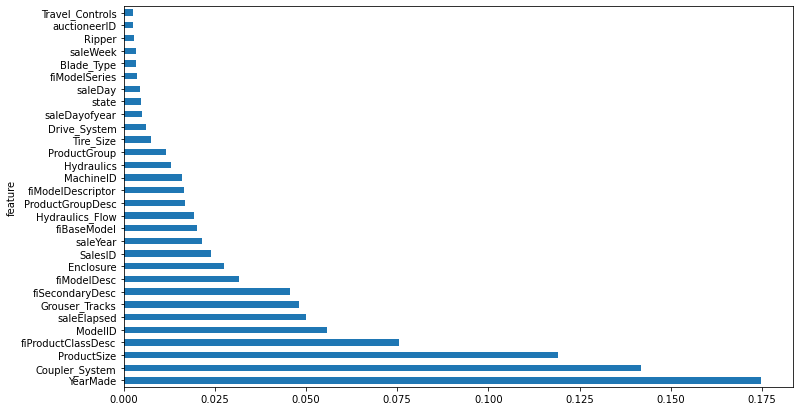

In [228]:
# lets build a plot from that
def plot_fi(fi):
    return fi.plot('feature', 'importance', 'barh', figsize=(12, 7), legend=False)

plot_fi(rf_feat_importance(m, xs)[:30]);

#### Removing Low-Importance Variables

In [229]:
# select columns with low feature importance
fi = rf_feat_importance(m, xs)
cols_to_keep = fi[fi.importance>.005].feature
len(cols_to_keep)

21

In [230]:
# lets retrain with only these columns
xs_imp = xs[cols_to_keep]
xs_valid_imp = xs_valid[cols_to_keep]

model_restricted = rf(xs_imp, y)

In [231]:
# compare with our unrestricted model
calculate_rmse(xs_imp, y, model_restricted), \
    calculate_rmse(xs_valid_imp, y_valid, model_restricted)

(0.181181, 0.230568)

Almost same accuracy but way less columns to wrap our head around.

In [232]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

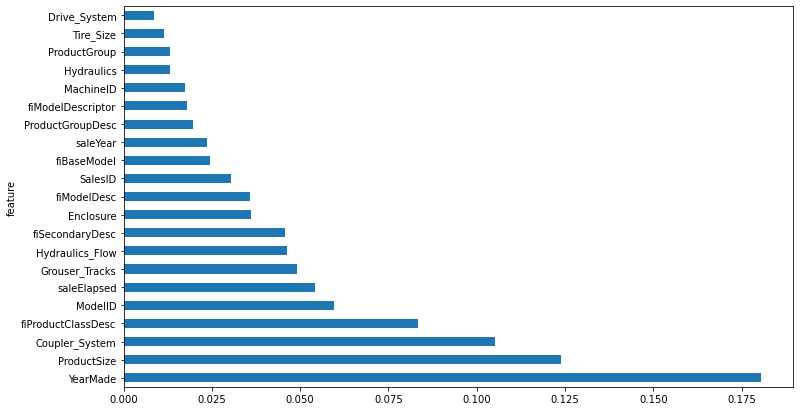

In [234]:
plot_fi(rf_feat_importance(model_restricted, xs_imp));

#### Removing Redundant Features

In [261]:
# create function for clustering columns
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, orientation='left', leaf_font_size=font_size)
    plt.show()

In [284]:
scipy.stats.spearmanr(xs_imp).correlation.shape, xs_imp.corr(method='spearman').shape

((21, 21), (21, 21))

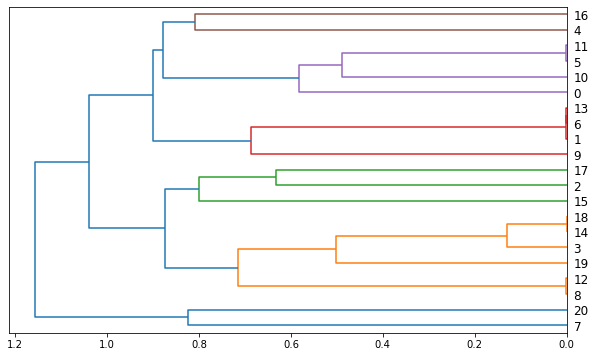

In [262]:
# plot related features
cluster_columns(xs_imp)

In [268]:
for i, c in enumerate(xs_imp.columns):
    print(i, c)

0 YearMade
1 Coupler_System
2 ProductSize
3 fiProductClassDesc
4 ModelID
5 saleElapsed
6 Grouser_Tracks
7 fiSecondaryDesc
8 fiModelDesc
9 Enclosure
10 SalesID
11 saleYear
12 fiBaseModel
13 Hydraulics_Flow
14 ProductGroupDesc
15 fiModelDescriptor
16 MachineID
17 Hydraulics
18 ProductGroup
19 Tire_Size
20 Drive_System


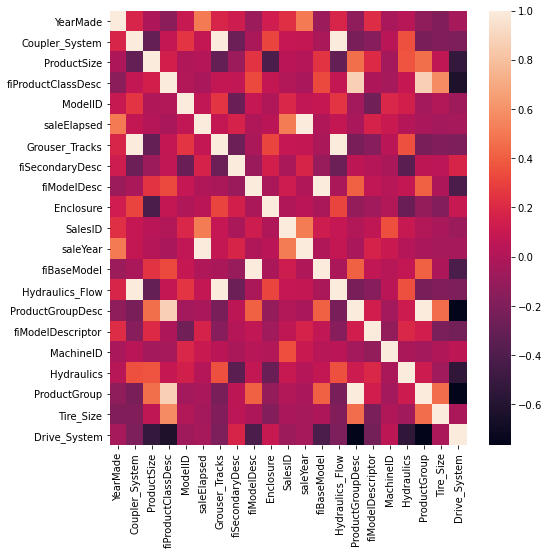

In [278]:
# or via correlation matrix
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(xs_imp.corr(method='spearman'), ax=ax);